# Term Project

### Name: Fidel C. Otero
### UTEID: fco229

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

### Maimonide's Rule

Maimonides is a popular Jewish philosopher and his teachings are applied in Jewish societies to this day.  Maimoinide's rule states that a class' size can reach a maximum limit of 40 students before being split in half (Once the size of a particular school grade level, cohsize, reaches 41 then that class is split into one with 20 students and another with 21 students).

This project will focus on the concept of Maimonide's rule. I had the motivation to perform this particular project by one of my other professors. My dataset is about 4077 Jewish classes that each has a classize, a grade, and an average score. We will clean up this dataset further, but below is what we have for now. My aim is to see if there is truly a relationship between class size and cohort size, and to see if this relationship has an effect on the average scores of individuals near the cutoff points at intervals of 40. The model that I will use is a multiple linear regression model and I expect that as class size increases, average scores decrease. I will evaluate this model using statsmodel.api to use the p-values to see if our results are statistically significant or not. I expect the model to work well with the data, however I fear that it will lack external validity to other classroom data sets that are not Jewish. 

Below is the dataset we are working with. Since there are 4076 observations, we will try to cut it down to 2000 to perform our analyses. 

In [61]:
school_df = pd.read_csv('ClassSizeRKD.csv')
school_df

,schlcode,cohsize,classize,tipuach,grade,coh_id,num_classrooms,avgscore
0,11005,35,35,24,4,1,1,65.354996
1,11006,54,27,38,4,3,2,58.059998
2,11006,54,27,38,4,3,2,60.245003
3,11009,38,38,6,4,5,1,77.535004
4,11010,73,37,3,4,7,2,69.000000
...,...,...,...,...,...,...,...,...
4072,61351,19,19,26,5,2013,1,74.880005
4073,61363,27,27,22,5,2016,1,74.815002
4074,61364,70,38,0,5,2018,2,73.729996
4075,61364,70,32,0,5,2018,2,75.529999


##### Source: https://plato.stanford.edu/entries/maimonides/

Our variables of interests will be class size, cohort size, and average score. Cohort size is defined as the size of the grade level, class size is the size of a class within a cohort, and average score is defined as the average test scores within each class. Now, we will create some variables and the reasoning for creating them will be explained later. The first variable that we will create is a dummy variable that denotes whether or not a cohort's size is greater than 40 or not. The second variable that we will create is a variable that will center our linear regression at 40. Finally, we will create an interaction variable that will interact the two previously created variables. 

In [62]:
# Here we create series that we will use for further analysis
classize = school_df['classize']
cohsize = school_df['cohsize']

school_df['gt40'] = (school_df['cohsize'] > 40).astype(int)
school_df['c40'] = (school_df['cohsize'] - 40)

# This variable is a variable that denotes whether or not a cohort's size is greater than 40 or not
gt40 = school_df['gt40']
# This variable is a variable that centers our linear regression at 40 to help us obtain a local average treatment effect (LATE)
c40 = school_df['c40']
# This variable is the interaction term 
gt40c40 = gt40 * c40

Before we take any more steps, it is important to visualize the data that we have. Since we are analyzing Jewish schools, it would be reasonable to assume that class size would experience a drop after cohort size reaches multiples of 40. Let us visualize our data to see if this truly holds. 

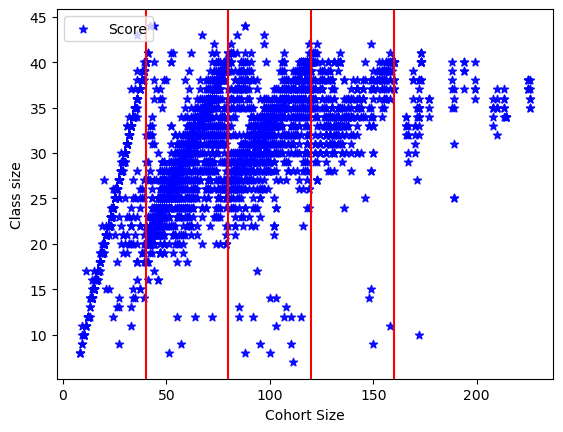

In [63]:
fig = plt.figure()
plt.scatter(cohsize, classize, c="blue", alpha=0.9, marker='*',label="Score")
plt.xlabel("Cohort Size")
plt.ylabel("Class size")
plt.legend(loc='upper left')
plt.axvline(x = 40, color = 'r', label = 'axvline - full height')
plt.axvline(x = 80, color = 'r', label = 'axvline - full height')
plt.axvline(x = 120, color = 'r', label = 'axvline - full height')
plt.axvline(x = 160, color = 'r', label = 'axvline - full height')

plt.show()


From the plot above, you can see that around 40, 80, 120, 160 (all intervals of 40) the class size drops. From this data, this would be a great setting for a regression discontinuity/kink design, which we can evaluate through the use of linear regression. 

#### Regression Kink Design Explanation

A regression kink design is a research method that exploits discontinuities/changes of slopes of dependent variables of interest after reaching a certain cutoff point in a running variable. At its core, a multiple linear regression model is used to obtain results. Our assumptions are as follows:

1. There is no change in the slope of the potential outcomes at the cutoff
2. Observable and unobservable factors that affect treatment and the outcome do not have a change in slope at the cutoff
3. We have a running variable that determines treatment
4. We assume these assumptions are true if people can't precisely control their value of the running variable

Because we are doing a regression kink design, we will run two regressions. One will be denoted as the 'first stage' which involves regressing our treatment variable on the running variable. The second will be denoted as the 'reduced form' which involves regressing our dependent variable of interest on the running variable.

##### Source: https://blogs.worldbank.org/impactevaluations/tools-trade-regression-kink-design

#### The First-Stage Linear Regression Model

Our linear regression model for this experiment will follow a standard regression kink design formula after making the correct assumptions as stated above.

Thus our linear regression model will be:

$classize = \beta_{0} + \beta_{1}gt40 + \beta_{2}ct40 + \beta_{3}gt40ct40 $

Essentially our dependent variable of interest for the first stage is class size. After receiving our results, the coefficient on gt40 will tell us the size of the discontinuity, ct40 will tell us the size of the slope before the discontinuity, and the interaction of gt40 and ct40 will provide us with the change in the slope after the cutoff value of 40. This will be our first stage regression. Essentially this regression will relate our instrument and our treatment variable.


Because we want to identify a local average treatment effect, we will create a bandwidth to only include values of c40 that have an absolute value of 30. 

In [64]:
new_school_df = school_df[abs(school_df['c40']) <= 30]
new_school_df

,schlcode,cohsize,classize,tipuach,grade,coh_id,num_classrooms,avgscore,gt40,c40
0,11005,35,35,24,4,1,1,65.354996,0,-5
1,11006,54,27,38,4,3,2,58.059998,1,14
2,11006,54,27,38,4,3,2,60.245003,1,14
3,11009,38,38,6,4,5,1,77.535004,0,-2
6,11013,65,31,8,4,9,2,59.105000,1,25
...,...,...,...,...,...,...,...,...,...,...
4072,61351,19,19,26,5,2013,1,74.880005,0,-21
4073,61363,27,27,22,5,2016,1,74.815002,0,-13
4074,61364,70,38,0,5,2018,2,73.729996,1,30
4075,61364,70,32,0,5,2018,2,75.529999,1,30


After cleaning the dataset and limiting the number of observations to 1916, we have successfully made our dataset no larger than 2000 observations. We will now reassign our previous variables to have them updated to our new dataframe. 

In [65]:
# Here we create series that we will use for further analysis
classize = new_school_df['classize']
cohsize = new_school_df['cohsize']

# This variable is a variable that denotes whether or not a cohort's size is greater than 40 or not
gt40 = new_school_df['gt40']
# This variable is a variable that centers our linear regression at 40 to help us obtain a local average treatment effect (LATE)
c40 = new_school_df['c40']
# This variable is the interaction term 
gt40c40 = gt40 * c40

#### Running the first-stage regression model

Now that we have updated our variables, it is time to run a linear regression to see our results. By using sklearn.linear_model LinearRegression, we are able to obtain our regression coefficients. 

##### Coefficient interpretations

1. The first coefficient, gt40, is -13.012359078940941. We interpret this as at the cutoff point, class size drops on average by about 13.
2. The coefficient, c40, is 0.7237558615605529. This number signifies the slope of the line before the cutoff point. This means that class size increases by 0.7237558615605529 as cohort size increases. 
3. The coefficient, gt40c40, is -0.33900696518803836. This number signifies the change in the slope after the cutoff point. This means that the class size increases by 0.7237558615605529 - 0.33900696518803836 after the cutoff point. 

In [67]:
my_X = np.vstack((gt40, c40, gt40c40)).T

reg = LinearRegression().fit(my_X, classize)

gt40_coef_fs = reg.coef_[0]
c40_coef_fs = reg.coef_[1]
gt40c40_coef_fs = reg.coef_[2]

print('Coefficient of gt40:', gt40_coef_fs)
print('Coefficient of c40:', c40_coef_fs)
print('Coefficient of gt40c40', gt40c40_coef_fs)

Coefficient of gt40: -13.012359078940941
Coefficient of c40: 0.7237558615605529
Coefficient of gt40c40 -0.33900696518803836


#### Verifying our results

We can verify our results using statsmodels.api to obtain our p-values for each regression coefficient. Each coefficient has a p-value of 0, meaning that each coefficient is statistically significant and rejects the null hypothesis that the specific coefficient is equal to 0.

In [50]:
import statsmodels.api as sm
from scipy import stats

my_X2 = sm.add_constant(my_X)
est = sm.OLS(classize, my_X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               classize   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     816.9
Date:                Thu, 13 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:54:23   Log-Likelihood:                -5319.9
No. Observations:                1916   AIC:                         1.065e+04
Df Residuals:                    1912   BIC:                         1.067e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.4176      0.330    104.144      0.0

#### The reduced-form regression model

Now that we have our first-stage regression coefficients, now we can run our reduced-form regression. The only thing that we perform is regress average score on gt40, c40, and the interaction term. Our multiple linear regression model is thus: 

$avgscore = \beta_{0} + \beta_{1}gt40 + \beta_{2}ct40 + \beta_{3}gt40ct40 $

Similar to the first-stage, essentially our dependent variable of interest for the reduced-form is average score. After receiving our results, the coefficient on gt40 will tell us the size of the discontinuity, ct40 will tell us the size of the slope before the discontinuity, and the interaction of gt40 and ct40 will provide us with the change in the slope after the cutoff value of 40. This will be our reduced-form regression. Essentially this regression will relate our running variable and our outcome variable.

In the code below, I realized that the LinearRegression would not work because average score had NaN or infinite values, thus to improve our regression results, I removed all observations with NaN values, thus the new size of the data frame is now 1912. 

In [51]:
new_school_df = school_df[abs(school_df['c40']) <= 30].dropna()
new_school_df

# Here we create series that we will use for further analysis
avgscore = new_school_df['avgscore']
cohsize = new_school_df['cohsize']

# This variable is a variable that denotes whether or not a cohort's size is greater than 40 or not
gt40 = new_school_df['gt40']

# This variable is a variable that centers our linear regression at 40 to help us obtain a local average treatment effect (LATE)
c40 = new_school_df['c40']

# This variable is the interaction term 
gt40c40 = gt40 * c40

#### Running the reduced-form regression model

Now that we have updated our variables for the final time, it is time to run the reduced-form linear regression to see our results. By using sklearn.linear_model LinearRegression, we are able to obtain our regression coefficients.


##### Coefficient interpretations

1. The first coefficient, gt40, is 2.7929356365406983. We interpret this as at the cutoff point, average score increases locally on average by about 2.7929356365406983 as cohort size increases. As a reminder, this is only a local average treatment effect. 
2. The coefficient, c40, is -0.17628814896655914. This number signifies the slope of the line before the cutoff point. This means that average score decreases by -0.17628814896655914 as cohort size increases. 
3. The coefficient, gt40c40, is 0.268131481102453. This number signifies the change in the slope after the cutoff point. This means that the average score increases by -0.17628814896655914 + 0.268131481102453 after the cutoff point. 

In [52]:
my_X = np.vstack((gt40, c40, gt40c40)).T
reg = LinearRegression().fit(my_X, avgscore)


gt40_coef_rd = reg.coef_[0]
c40_coef_rd = reg.coef_[1]
gt40c40_coef_rd = reg.coef_[2]

print('Coefficient of gt40:', gt40_coef)
print('Coefficient of c40:', c40_coef)
print('Coefficient of gt40c40', gt40c40_coef)

Coefficient of gt40: 2.7929356365406983
Coefficient of c40: -0.17628814896655914
Coefficient of gt40c40 0.268131481102453


In [53]:
import statsmodels.api as sm
from scipy import stats

my_X2 = sm.add_constant(my_X)
est = sm.OLS(avgscore, my_X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               avgscore   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     14.15
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           4.02e-09
Time:                        00:54:30   Log-Likelihood:                -6845.9
No. Observations:                1912   AIC:                         1.370e+04
Df Residuals:                    1908   BIC:                         1.372e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.5836      0.740     88.590      0.0

#### Overall interpretation of our results

As a reminder, our aim is to see the effect of class size on average score. But the regressions that we ran involved regressing class size on cohort size and average score on cohort size. So how do we obtain the estimate of the effect of class size on average score? All we do is divide the coefficient from the reduced-form by the coefficient from the first-stage and we can interpret that as the causal effect of class size on average score.

Below, we obtain the effects of class size on average score. First we obtain the regression discontinuity design effect which is 0.268131481102453. We interpret this as class size causes a change in the level of average score to increase at the cutoff by around 0.268131481102453. The regression kink design effect is -0.7909320711264072, and we interpret this as a change in the slope at the cutoff of -0.7909320711264072 which signifies that average score will decrease at the cutoff as class size increases. Since all of our regression coefficients that we obtained were statistically significant, we can say that our coefficients are statistically different from zero and relate to each other in a meaningful way. 

In [68]:
# This is the effect of class size on average score
rdd = gt40_coef_rd / gt40_coef_fs
print('This is the effect of class size on average score:', gt40c40_coef_rd)

rkd = gt40c40_coef_rd / gt40c40_coef_fs
print('This is the change in the slope of class size versus test score around the cutoff point:', rkd)

This is the effect of class size on average score: 0.268131481102453
This is the change in the slope of class size versus test score around the cutoff point: -0.7909320711264072
